In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from ast import literal_eval
from typing import List
import re

import context

from cont_gen.utils import load_jsonl, save_jsonl
from cont_gen.evaluate.cal_metrics import cal_collective_point_metrics, get_point_counts, get_doc_metrics

In [2]:
os.chdir('/storage_fast/rhshui/workspace/contract_review/')

In [3]:
# test_data_id = load_jsonl('data/ood_split/seed42_tr29/pmt_01/test_data_id.jsonl')
# test_data_ood = load_jsonl('data/ood_split/seed42_tr29/pmt_01/test_data_ood.jsonl')
cvt = {'answers': lambda k: ' '.join(literal_eval(k))}

test_meta_id = pd.read_csv('data/ood_split/seed42_tr29/test_meta_id.csv', converters = cvt)
test_meta_ood = pd.read_csv('data/ood_split/seed42_tr29/test_meta_ood.csv', converters = cvt)

In [4]:
test_meta_ood.iloc[0].answers

'SUPPLY CONTRACT'

In [7]:
def get_ckpt_paths(run_dir) -> List[Path]:
    run_dir = Path(run_dir)
    ckpt_dirs = list(run_dir.glob('checkpoint-*'))
    # sort by global step
    def get_step(name):
        step = int(re.search(r'checkpoint-(.*)', name).group(1))
        return step
    step_path = [(get_step(k.name), k) for k in ckpt_dirs]
    step_path.sort(key = lambda k: k[0])

    return [k[1] for k in step_path]

def get_clause_metrics(ground_df, pred_df):
    # map from q_id to dataframe
    q2df_ground = {k:v for k,v in ground_df.groupby('q_id')}
    q2df_pred = {k:v for k,v in pred_df.groupby('q_id')}

    # get metrics of each q_id
    q2met = {}
    for q_id in q2df_ground.keys():
        q2met[q_id] = cal_collective_point_metrics(q2df_ground[q_id], q2df_pred[q_id])
    
    # add q_id to metric dt
    met_comb = [{'q_id': k, **v} for k,v in q2met.items()]
    met_df = pd.DataFrame(met_comb)
    return met_df

def parse_pred(text: str):
    if text == 'No' or text == 'No.':
        return ''
    else:
        return text.removeprefix('Yes.')

def handle_one_ckpt(ckpt_dir, is_ood, part = 'sampled', overwrite = False):
    ckpt_dir = Path(ckpt_dir)
    split_name = 'ood' if is_ood else 'id'
    save_path = ckpt_dir / f'detail_metrics_{split_name}_{part}.csv'
    if save_path.exists() and not overwrite:
        print(f'metrics already exist: {save_path.name}')
        return

    ground_df = test_meta_ood if is_ood else test_meta_id

    pred_path = ckpt_dir / f'predictions_{split_name}_{part}.jsonl'
    if not pred_path.exists():
        print(f'prediction not exist, skip. ({pred_path.name})')
        return
    pred_df = pd.DataFrame(load_jsonl(pred_path))
    pred_df['prediction'] = pred_df['prediction'].apply(parse_pred)
    
    met_df = get_clause_metrics(ground_df, pred_df)
    met_df.to_csv(ckpt_dir / f'detail_metrics_{split_name}_{part}.csv', index = False)

def get_critic_metrics(ckpt_dir, is_ood, part = 'sampled'):
    ckpt_dir = Path(ckpt_dir)
    split_name = 'ood' if is_ood else 'id'
    save_path = ckpt_dir / f'detail_metrics_{split_name}_{part}.csv'
    met_df = pd.read_csv(save_path)
    ave_dt = met_df.apply(np.mean).to_dict()
    return {k:v for k,v in ave_dt.items() if k.startswith('docsum')}

def print_critic_metrics(ckpt, is_ood, part = 'sampled'):
    try:
        ave_dt = get_critic_metrics(ckpt, is_ood = is_ood, part = part)
    except:
        return
    ave_dt = [f'{k}= {v:.4f}' for k,v in ave_dt.items()]
    met_str = '; '.join(ave_dt)
    print(f'{ckpt.name}: {met_str}')

In [6]:
# This is an example
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)

pred_path = ckpt_dirs[-1] / f'predictions_ood_sampled.jsonl'
pred_df = pd.DataFrame(load_jsonl(pred_path))
pred_df['prediction'] = pred_df['prediction'].apply(parse_pred)

met_df = get_clause_metrics(test_meta_ood, pred_df)

print(met_df)

In [8]:
# Handle flan-t5
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
for ckpt_dir in ckpt_dirs:
    print(f'Handle {ckpt_dir}')
    # handle_one_ckpt(ckpt_dir, True, overwrite = True)
    handle_one_ckpt(ckpt_dir, False, overwrite=True)

Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0/checkpoint-3721
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0/checkpoint-7442
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0/checkpoint-11163
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0/checkpoint-14884
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0/checkpoint-18605


In [9]:
print('-'*10 + 'OOD Metrics')
for ckpt in ckpt_dirs:
    print_critic_metrics(ckpt, is_ood = True)
print('-'*10 + 'In-distribution Metrics')
for ckpt in ckpt_dirs:
    print_critic_metrics(ckpt, is_ood = False)

----------OOD Metrics
checkpoint-3721: docsum_p= 0.6677; docsum_r= 0.3039; docsum_f1= 0.3792; docsum_iou= 0.2715
checkpoint-7442: docsum_p= 0.6596; docsum_r= 0.2997; docsum_f1= 0.3531; docsum_iou= 0.2542
checkpoint-11163: docsum_p= 0.6157; docsum_r= 0.3693; docsum_f1= 0.3968; docsum_iou= 0.2819
checkpoint-14884: docsum_p= 0.6086; docsum_r= 0.3902; docsum_f1= 0.4004; docsum_iou= 0.2912
checkpoint-18605: docsum_p= 0.6297; docsum_r= 0.3388; docsum_f1= 0.3721; docsum_iou= 0.2662
----------In-distribution Metrics
checkpoint-3721: docsum_p= 0.7156; docsum_r= 0.4190; docsum_f1= 0.4503; docsum_iou= 0.3194
checkpoint-7442: docsum_p= 0.7133; docsum_r= 0.4697; docsum_f1= 0.4878; docsum_iou= 0.3585
checkpoint-11163: docsum_p= 0.6194; docsum_r= 0.5206; docsum_f1= 0.4992; docsum_iou= 0.3564
checkpoint-14884: docsum_p= 0.6086; docsum_r= 0.5297; docsum_f1= 0.5188; docsum_iou= 0.3741
checkpoint-18605: docsum_p= 0.6870; docsum_r= 0.4989; docsum_f1= 0.5112; docsum_iou= 0.3698


In [10]:
# Handle phi-1_5
run_dir = Path('runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
for ckpt_dir in ckpt_dirs:
    print(f'Handle {ckpt_dir}')
    handle_one_ckpt(ckpt_dir, is_ood = True, overwrite=True)
    handle_one_ckpt(ckpt_dir, is_ood = False, overwrite=True)

Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0/checkpoint-14886
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0/checkpoint-29772
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0/checkpoint-44658
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0/checkpoint-59544
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_lr1e-5_bs16_wd0.0/checkpoint-74430


In [11]:
print('-'*10 + 'OOD Metrics')
for ckpt in ckpt_dirs:
    print_critic_metrics(ckpt, is_ood = True)
print('-'*10 + 'In-distribution Metrics')
for ckpt in ckpt_dirs:
    print_critic_metrics(ckpt, is_ood = False)

----------OOD Metrics
checkpoint-14886: docsum_p= 0.8745; docsum_r= 0.0302; docsum_f1= 0.0502; docsum_iou= 0.0286
checkpoint-29772: docsum_p= 0.8243; docsum_r= 0.1390; docsum_f1= 0.1887; docsum_iou= 0.1187
checkpoint-44658: docsum_p= 0.5644; docsum_r= 0.1820; docsum_f1= 0.2093; docsum_iou= 0.1252
checkpoint-59544: docsum_p= 0.5487; docsum_r= 0.2138; docsum_f1= 0.2251; docsum_iou= 0.1344
checkpoint-74430: docsum_p= 0.6264; docsum_r= 0.1933; docsum_f1= 0.2208; docsum_iou= 0.1345
----------In-distribution Metrics
checkpoint-14886: docsum_p= 0.9830; docsum_r= 0.0614; docsum_f1= 0.0738; docsum_iou= 0.0601
checkpoint-29772: docsum_p= 0.8105; docsum_r= 0.1111; docsum_f1= 0.1528; docsum_iou= 0.1083
checkpoint-44658: docsum_p= 0.6594; docsum_r= 0.1963; docsum_f1= 0.2513; docsum_iou= 0.1720
checkpoint-59544: docsum_p= 0.6435; docsum_r= 0.2116; docsum_f1= 0.2512; docsum_iou= 0.1694
checkpoint-74430: docsum_p= 0.6681; docsum_r= 0.1913; docsum_f1= 0.2421; docsum_iou= 0.1684


In [15]:
# Handle yes_no prompt
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
for ckpt_dir in ckpt_dirs:
    print(f'Handle {ckpt_dir}')
    handle_one_ckpt(ckpt_dir, True, overwrite = False)
    # handle_one_ckpt(ckpt_dir, False, overwrite=True)

run_dir = Path('runs/ood/phi-1_5/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
for ckpt_dir in ckpt_dirs:
    print(f'Handle {ckpt_dir}')
    handle_one_ckpt(ckpt_dir, is_ood = True, overwrite=False)
    # handle_one_ckpt(ckpt_dir, is_ood = False, overwrite=True)

Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0/checkpoint-3721
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0/checkpoint-7442
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0/checkpoint-11163
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0/checkpoint-14884
Handle runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0/checkpoint-18605
prediction not exist, skip. (predictions_ood_sampled.jsonl)
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0/checkpoint-7443
prediction not exist, skip. (predictions_ood_sampled.jsonl)
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0/checkpoint-14886
prediction not exist, skip. (predictions_ood_sampled.jsonl)
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0/checkpoint-22329
Handle runs/ood/phi-1_5/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0/checkpoint-29772


In [17]:
# run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_yes_no_lr1e-4_bs16_wd0.0')
run_dir = Path('runs/ood/phi-1_5/seed42_tr29/pmt_01_yes_no_lr1e-5_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
print('-'*10 + 'OOD Metrics')
for ckpt in ckpt_dirs:
    print_critic_metrics(ckpt, is_ood = True)
# print('-'*10 + 'In-distribution Metrics')
# for ckpt in ckpt_dirs:
#     print_critic_metrics(ckpt, is_ood = False)

----------OOD Metrics
checkpoint-22329: docsum_p= 0.6411; docsum_r= 0.2050; docsum_f1= 0.2691; docsum_iou= 0.1739
checkpoint-29772: docsum_p= 0.4363; docsum_r= 0.2907; docsum_f1= 0.3183; docsum_iou= 0.2068


In [6]:
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
save_path = ckpt_dirs[-1] / f'detail_metrics_ood_sampled.csv'
met_df = pd.read_csv(save_path)

In [7]:
met_df

,q_id,macro_p,macro_r,macro_f1,macro_iou,micro_p,micro_r,micro_f1,micro_iou
0,0,0.906668,0.899838,0.869500,0.868402,0.044362,0.067797,0.053631,0.027555
1,1,0.912169,0.836183,0.826645,0.825926,0.120419,0.035549,0.054893,0.028221
2,5,0.999218,0.991226,0.992081,0.991074,0.985143,0.478092,0.643764,0.474670
3,6,0.982684,0.994030,0.976903,0.976714,0.540166,0.724907,0.619048,0.448276
4,7,1.000000,0.961980,0.962353,0.961980,1.000000,0.583609,0.737062,0.583609
5,8,1.000000,0.996753,0.996753,0.996753,1.000000,0.000000,0.000000,0.000000
6,14,0.991546,0.995127,0.988871,0.988438,0.655654,0.732955,0.692153,0.529231
7,15,0.978583,0.983655,0.964295,0.963659,0.538407,0.579666,0.558275,0.387228
8,17,0.987993,0.964160,0.955229,0.954299,0.729139,0.326222,0.450768,0.290962
9,27,1.000000,0.980519,0.980519,0.980519,1.000000,0.000000,0.000000,0.000000


### Visualize

In [52]:
import matplotlib.pyplot as plt

In [55]:
run_dir = Path('runs/ood/flan-t5-large/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0')
ckpt_dirs = get_ckpt_paths(run_dir)
ckpt_dir = ckpt_dirs[-1]
# get detail results
save_path = ckpt_dir / f'detail_metrics_ood_sampled.csv'
met_df_ood = pd.read_csv(save_path)
iou_mat_ood = met_df_ood['micro_iou']

save_path = ckpt_dir / f'detail_metrics_id_sampled.csv'
met_df_id = pd.read_csv(save_path)
iou_mat_id = met_df_id['micro_iou']

In [61]:
all_info = pd.read_csv('data/clause/all_info.csv')
q2name = {i: row['clause_type'] for i,row in all_info.iterrows()}

In [74]:
def plot_clause_bar(met_df):
    x_labels = met_df['q_id'].apply(lambda k: q2name[k]).to_list()
    y = met_df['micro_iou'].to_list()
    ax = plt.gca()
    # fig, ax = plt.subplots()
    ax.barh(range(len(y)), y)
    ax.set_yticks(range(len(y)))
    ax.set_yticklabels(x_labels)

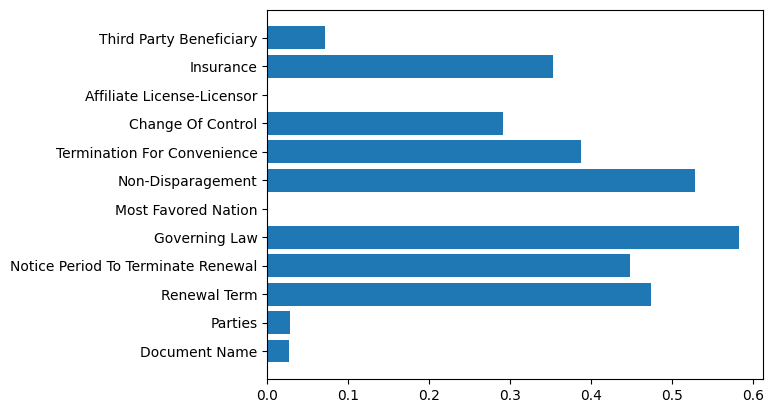

In [75]:
plot_clause_bar(met_df_ood)

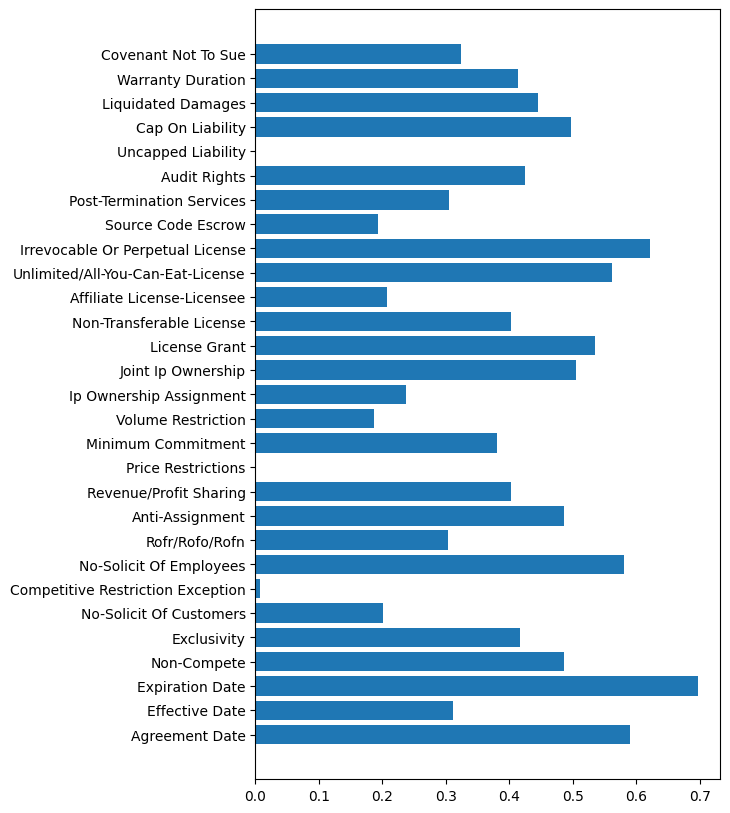

In [77]:
plt.figure(figsize = (6,10))
plot_clause_bar(met_df_id)

In [67]:
met_df_ood['q_id'].apply(lambda k: q2name[k])

0                          Document Name
1                                Parties
2                           Renewal Term
3     Notice Period To Terminate Renewal
4                          Governing Law
5                    Most Favored Nation
6                      Non-Disparagement
7            Termination For Convenience
8                      Change Of Control
9             Affiliate License-Licensor
10                             Insurance
11               Third Party Beneficiary
Name: q_id, dtype: object